In [1]:
# MOUNTS GOOGLE DRIVE ##########################################################################

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# IMPORTS LIBRARIES NEEDED #######################################################################

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, SGD
from keras import layers
from keras import models

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

from keras.callbacks import ModelCheckpoint, EarlyStopping


Using TensorFlow backend.


In [0]:
# DEFINES SOME PARAMETERS ########################################################################

train_path  = "/content/drive/My Drive/ML/projects/chest_xray/images/train"
test_path   = "/content/drive/My Drive/ML/projects/chest_xray/images/test"
val_path    = "/content/drive/My Drive/ML/projects/chest_xray/images/val"
models_path = "/content/drive/My Drive/ML/projects/chest_xray/cnn_models/"

#model_file_name ="xception.06-0.875.h5"
#model_file_name ="xception.15-0.938.h5"

BATCH_SIZE = 32

IM_HEIGHT = 200
IM_WIDTH = 200

NTRAIN_IMAGES = 5216
NTEST_IMAGES = 624
NVAL_IMAGES = 16

In [0]:
# CREATES DATA GENERATORS FOR READING AND AUGMENTING IMAGES ######################################

# The train generator will rotate, shift verticaly and horizontaly, zoom, shrink, 
# and flip images horizontally
train_datagen = ImageDataGenerator(
                                   preprocessing_function = preprocess_input,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rescale = 1./255                           )

test_datagen = ImageDataGenerator(
                                   preprocessing_function = preprocess_input,
                                   rescale = 1./255                           )

train_generator = train_datagen.flow_from_directory(train_path,
                                           target_size = (IM_HEIGHT, IM_WIDTH),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           class_mode = 'categorical')

test_generator  = test_datagen.flow_from_directory( test_path,
                                           target_size = (IM_HEIGHT, IM_WIDTH),
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'categorical')

val_generator   = test_datagen.flow_from_directory( val_path,
                                           target_size=(IM_HEIGHT, IM_WIDTH),
                                           batch_size=1,
                                           class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
# CREATES THE MOBILENET MODEL #########################################################################

base_model = MobileNet(weights ='imagenet', 
                      include_top = False,
                      input_shape = ( IM_HEIGHT, IM_WIDTH, 3) )

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
predictions = layers.Dense( 2, activation='softmax')(x)

model = models.Model( inputs=base_model.input, outputs=predictions)

# TRANSFER LEARNING -> This is commented because Transfer Learning produced worse results when
# compared to full training
# Freezes weights of model from block1 until block5
#for layer in base_model.layers[:46]:    layer.trainable=False
#for layer in base_model.layers[46:]:    layer.trainable=True

#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

#optim = RMSprop(lr=0.0007) 
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'] )

model.summary()

# Prints full model layers
#for i,layer in enumerate(model.layers):  
#  if(layer.trainable == True): print(i,layer.name)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 201, 201, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 100, 100, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 100, 100, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 100, 100, 32)      128 

In [0]:
# TRAINS THE MODEL (FULL) ############################################################################

# Configures callback function for saving the model when val_acc improves
h5_filepath = models_path + "mobilenet.{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint( h5_filepath, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)  # number of epochs between checkpoints

# Configures callback to stop training when val_acc stops improving
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, 
#                       mode='auto')
#callbacks_list = [checkpoint, early]
callbacks_list = [checkpoint]

history = model.fit_generator(train_generator,
                              steps_per_epoch = NTRAIN_IMAGES // BATCH_SIZE,
                              epochs = 100,
                              validation_data = test_generator,
                              validation_steps = NTEST_IMAGES // BATCH_SIZE,
                              #shuffle = True, 
                              callbacks = callbacks_list )

Epoch 1/100
163/163 [==============================] - 1440s 9s/step - loss: 0.3424 - acc: 0.9103 - val_loss: 0.3108 - val_acc: 0.8997

Epoch 00001: val_acc improved from -inf to 0.89967, saving model to /content/drive/My Drive/ML/projects/chest_xray/cnn_models/mobilenet.01-0.8997.h5
Epoch 2/100
163/163 [==============================] - 111s 682ms/step - loss: 0.1668 - acc: 0.9431 - val_loss: 3.8016 - val_acc: 0.4476

Epoch 00002: val_acc did not improve from 0.89967
Epoch 3/100
163/163 [==============================] - 111s 681ms/step - loss: 0.1271 - acc: 0.9557 - val_loss: 1.5551 - val_acc: 0.6892

Epoch 00003: val_acc did not improve from 0.89967
Epoch 4/100
163/163 [==============================] - 111s 681ms/step - loss: 0.1066 - acc: 0.9634 - val_loss: 1.9774 - val_acc: 0.6791

Epoch 00004: val_acc did not improve from 0.89967
Epoch 5/100
163/163 [==============================] - 111s 682ms/step - loss: 0.1051 - acc: 0.9643 - val_loss: 2.3119 - val_acc: 0.6047

Epoch 00005: 

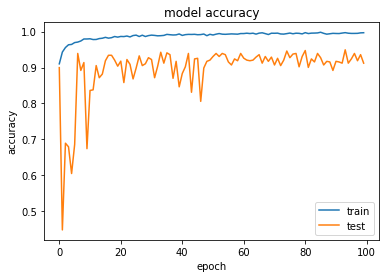

In [0]:
# PLOTS TRAINING RESULTS ###############################################################################

# Plots history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#from sklearn.metrics import classification_report
#pred = model.predict(test_set)
#print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

In [0]:
model_path = "/content/drive/My Drive/ML/projects/chest_xray/cnn_models/chest_xray_mobilenet.h5"

model.save_weights(model_path)
